In [1]:
#%% Paket för att lösa HUPP:en %%# 

# Standard paket för att hantera matamatik och arrayer
import numpy as np

# Standard paket för att plotta figurer
import matplotlib.pyplot as plt

# Vi lånar funktionen 'io' från scipy för att kunna importera .mat-filer på 
# ett smidigt sätt
import scipy.io as io

In [2]:
#%% Funktioner för HUPP:en %%#

def fft2c(x):
    '''
    2D Fourier transform
    
    Denna är perfekt som den är. Bara att använda!
    '''
    return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(x)))

def ifft2c(x):
    '''
    2D inverse Fourier transform
    
    Denna är perfekt som den är. Bara att använda!
    '''
    return np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(x)))


def PAS(E1, L, N, a, lam0, n):
    '''
    Funktion för att propagera E1 sträckan L genom PAS
    
    Funktionen är ej klar! Byt ut alla '.x.' för att få PAS funktionen att fungera
    '''
    
    # Varje sampelpunkt i k-planet motsvarar en plan våg med en viss riktning [kx,ky,kz]
    delta_k = 2*np.pi/(N*a)                                              # Samplingsavstånd i k-planet
    
    kx      = np.arange(-(N/2)*delta_k, (N/2)*delta_k, delta_k) # Vektor med samplingspunkter i kx-led
    ky      = kx                                                # och ky-led
    
    KX, KY  = np.meshgrid(kx,ky)                                # k-vektorns x- resp y-komponent i varje 
                                                                # sampelpunkt i k-planet
    
    k = 2*np.pi*n/(lam0)                                        # k-vektorns längd (skalär) för en plan våg i ett material med brytningsindex n
    
    KZ = np.sqrt(k**2 - KX**2 - KY**2, dtype=complex)                   # k-vektorns z-komponent i varje sampelpunkt.
                                                       # dtype=complex tillåter np.sqrt att evaluera till ett komplext tal
    
    fasfaktor_propagation = np.exp(1j*KZ*L) # Faktor för varje sampelpunkt i k-planet
                                           # multas med för att propagera sträckan L i z-led 

    A  = (a**2)/((2*np.pi)**2)*fft2c(E1)                # Planvågsspektrum i Plan 1
    B  = A*fasfaktor_propagation        # Planvågsspektrum i Plan 2 (Planvågsspektrum i Plan 1 multat med fasfaktorn för propagation)
    E2 = (delta_k**2)*(N**2)*ifft2c(B)
    
    return E2


Text(0, 0.5, 'y $[$mm$]$')

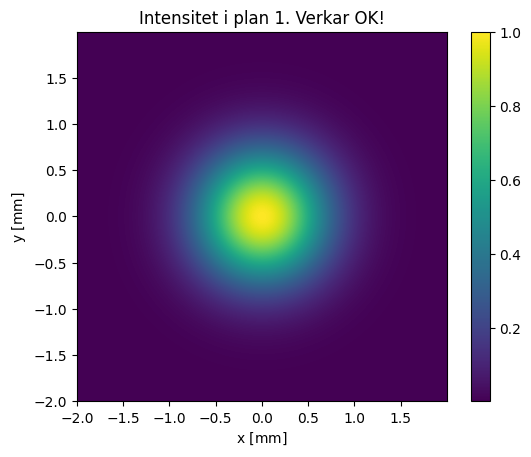

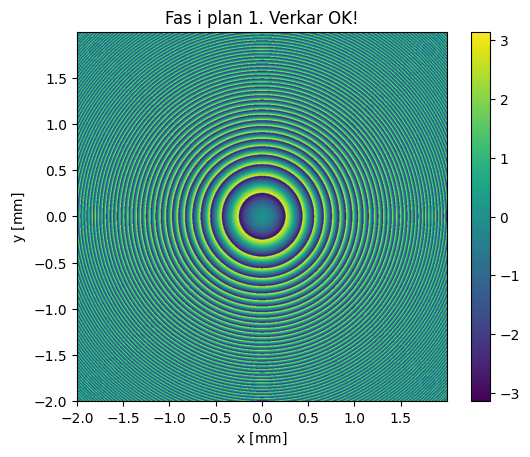

In [3]:
#%% Propagera fält med PAS %%#
    
N               = 2**10                 # NxN är antalet samplade punkter (rekommenderad storlek N=1024)
sidlaengd_Plan1 = 4e-3                  # Det samplade områdets storlek (i x- eller y-led) i Plan 1 (rekommenderad storlek 4 mm)
a               = sidlaengd_Plan1/N     # Samplingsavstånd i Plan 1 (och Plan 2 eftersom vi använder PAS)
L               = 100e-3                # Propagationssträcka (dvs avstånd mellan Plan 1 och 2)

lambda_noll = 633e-9                    # Vakuumvåglängd för rött ljus från en HeNe-laser
n_medium    = 1                         # Brytningsindex för medium mellan Plan 1 och 2
k           = 2*np.pi/lambda_noll*n_medium          # K-vektorns längd 

### Definera koordianter i plan 1 ###
x = np.arange(-(N/2)*a, (N/2)*a, a)     # Vektor med sampelpositioner i x-led
y = x                                   # och y-led

X, Y = np.meshgrid(x, y)                # Koordinatmatriser med x- och y-värdet i varje sampelposition
R    = np.sqrt(X**2 + Y**2)             # Avståndet till origo för varje sampelpunkt

### Definera lins och cirkulär aperatur ###
f_lins = 100e-3                         # Fokallängd på linsen före Plan 1
T_lins = np.exp(-1j*k*R**2/(2*f_lins))  # Transmissionsfunktion för en lins (linsen är TOK)

D_aperture = 2e-3                       # Diameter för apertur
T_aperture = R < (D_aperture/2)         # Transmissionsfunktion för en cirkulär apertur ("pupill")

### Definera fält i plan 1 ###
omega1      = 1e-3                      # 1/e2-radie (för intensiteten, dvs 1/e-radie för amplituden) för infallande Gaussiskt fält
E1_in_gauss = np.exp(-R**2/omega1**2)   # Infallande fält: Gaussiskt med plana vågfronter och normalinfall (dvs konstant fas, här=0)
E1_in_konst = np.ones(X.shape)          # Infallande fält: Konstant i hela plan 1. np.ones(X.shape) ger en matris fylld med ettor som har samma storlek som X


E1_gauss    = E1_in_gauss*T_lins         # Fältet i Plan 1 (precis efter linsen) för gaussisk stråle 
E1_cirkular = E1_in_konst*T_aperture*T_lins      # Fältet i Plan 1 (precis efter linsen) för konstant fält som passerat genom cirkulär apertur *** Ej klar 


# E1          = E1_cirkular  # Välj fall!
E1          = E1_gauss

I1      = np.abs(E1)**2     # Intensiteten är prop mot kvadraten på fältets amplitud (normalt struntar man i proportionalitetskonstanten)
I1_norm = I1/np.max(I1)     # Då vi inte är intresserade av det absoluta värdet av intensiteten så kan det vara trevligt att noramlizera intensiten innan vi plottar


### Plotta intensitet i plan 1 ###
x_mm = x*1e3
y_mm = y*1e3

plt.figure(1)
image = plt.imshow(I1_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 1. Verkar OK!')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')

### Plotta fas i plan 1 ###
plt.figure(2)
image = plt.imshow(np.angle(E1), extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Fas i plan 1. Verkar OK!')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')





Text(0, 0.5, 'y $[$mm$]$')

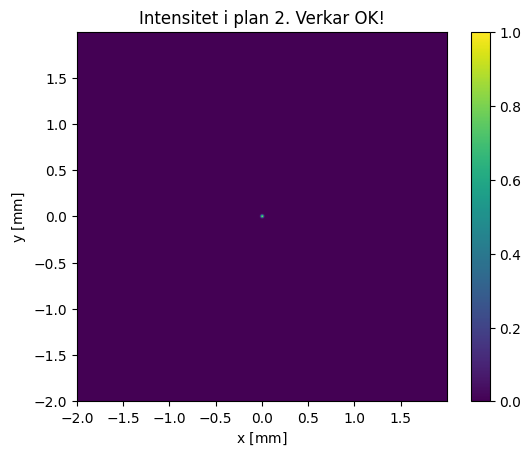

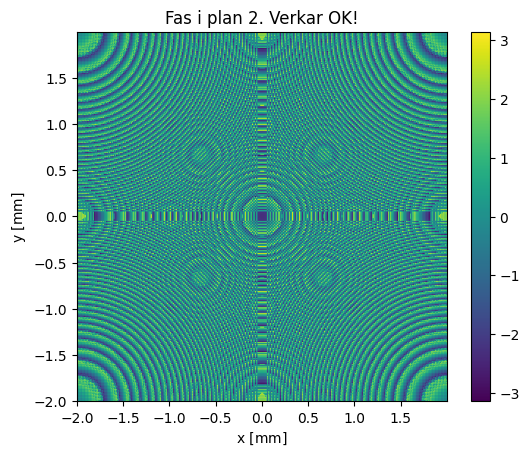

In [4]:
#%% Propagera till plan 2 %%#
E2      = PAS(E1, L, N, a, lambda_noll, n_medium)         # Propagera med vår PAS funktion
I2      = np.abs(E2)**2    # Intesitet i plan 2
I2_norm = I2/np.max(I2)    # Normaliserad intensitet i plan 2 för att plotta


### Plotta intensitet i plan 2 ###
plt.figure(1)
image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Intensitet i plan 2. Verkar OK!')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')

### Plotta fas i plan 2 ###
plt.figure(2)
image = plt.imshow(np.angle(E2), extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
plt.colorbar(image)

plt.title(r'Fas i plan 2. Verkar OK!')
plt.xlabel(r'x $[$mm$]$')
plt.ylabel(r'y $[$mm$]$')

In [5]:
#%% Två tips till uppgift 6! %%#

# Ladda in DOE såhär!
DOE = np.flip(io.loadmat('T_DOE_gen2.mat'))

E1_

# Fältet som har propagerats genom DOE och 'de vises lins' är smidigt att
# plotta i logaritmisk skala för att bilden ska vara tydlig.
# Alltså plotta fältet i plan 2 så här!
# I2      = np.abs(E2)**2    
# I2_norm = np.log(I2/np.max(I2))  # Log av den normaliserade intensiteten i plan 2

# x_mm = x*1e3
# y_mm = y*1e3

# plt.figure(1)
# image = plt.imshow(I2_norm, extent = [x_mm.min(), x_mm.max(), y_mm.min(), y_mm.max()])
# plt.colorbar(image)

NameError: name 'E1_' is not defined